### CUNY Data 620 - Web Analytics, Summer 2020
**Group Homework Assignment 6**  
**Prof:** Alain Ledon  
**Members:** Misha Kollontai, Amber Ferger, Zach Alexander, Subhalaxmi Rout  

**Youtube Link:** 

### Instructions

It can be useful to be able to classify new "test" documents using already classified "training" documents. <br>A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam. <br>Here is one example of such data: http://archive.ics.uci.edu/ml/datasets/Spambase

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn import svm, tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using the link mentioned above we will download 2 files i.e "spambase.data" and "spambase.names".<br> The spambase.data file contains various parameters for each file as well as a classificationof ham or spam (i.e 1 = spam, 0 = Not spam). The spambase.names file contains the descriptions of each of the features. We will extract these features from the file and apply them to the dataset to create models. 

In [2]:
# extract feature from spambase.names file.

# created an empty feature list
categories = []

# open file 
feature_file = open('data/spambase.names')
# remove '\n', split the text,  and match with word_freq|char_freq feature 
for line in feature_file:
    if not re.match(r'\|', line):
        line = line.rstrip()
        if re.search(r'(word_freq_|char_freq_|capital_run_length_).+', line):   
            words = line.split()
            first_word = words[0]
            categories.append(first_word[:-1])
#The list of features in the names file doesn't include the column definind spam/ham, so let's add one. 

categories.append('spam')
categories[:5]

['word_freq_make',
 'word_freq_address',
 'word_freq_all',
 'word_freq_3d',
 'word_freq_our']

Let's now load the data from the data file and apply our 'categories' list as the column header. 

In [3]:
data=pd.read_csv('data/spambase.data', header=None)
data.columns = categories

Let's take a look at our dataset ot see how much spam and how much ham we have. 

In [4]:
# Count spam and non-spam
count_spam = len(data[data.spam == 1])
count_nonspam = len(data[data.spam == 0])

print("Spam: %d" %count_spam)
print("Non-spam: %d" %count_nonspam)

Spam: 1813
Non-spam: 2788


In [5]:
data.head(4)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1


#### Data splitting:

This table consists of 58 columns, we will devide the dataset into 2 parts i.e the train and the test set. Train data is 75% of data and test data is 25% of data. We will create two variables: the output will be the 'spam' column, the input will be everything else. We also want to ensure that we stratify the model so that we have a representative breakdown of Spam and Ham. 

In [6]:
X = data.values[:, 0:57]
Y = data.values[:, 57]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 4, stratify=Y)

Parameter test_size is given value 0.25. It means test set will be 25% of the whole dataset and training set will be 75%. Parameter random_state is a pseudo-random number generator state used for random sampling.

#### Model 1: Support Vector machine

We will create model Support Vector machine algorithm and will create confusion matrix and the accuracy. 

In [7]:
svm_model = svm.SVC()
svm_model.fit(X_train, Y_train)

# Prediction
svm_pred = svm_model.predict(X_test)

In [8]:
# find accuracy on the Test Set
print(accuracy_score(Y_test, svm_pred))

0.7115551694178974


In [9]:
# Determine Performance Metrics
def perf_metrics(y_test, prediction):
    print(confusion_matrix(y_test, prediction))
    print(classification_report(y_test,prediction))

perf_metrics(Y_test,svm_pred)

[[618  79]
 [253 201]]
              precision    recall  f1-score   support

         0.0       0.71      0.89      0.79       697
         1.0       0.72      0.44      0.55       454

    accuracy                           0.71      1151
   macro avg       0.71      0.66      0.67      1151
weighted avg       0.71      0.71      0.69      1151



Using a baseline support vector machine(SVM) the accuracy of predicting spam messages/emails is 71%.

In a situation like this the more important measure is probably Precision - since we want to ensure that while we are filtering out Spam, we do our best to send all actual emails to the inbox. No one wants to miss an important email due to the spam filter!

#### Model 2: K Nearest Neighbors

When putting together a K-Nearest Neighbors model we wanted to ensure we were selecting the optimal number of neighbors for our dataset. To do so we looped through them and identified the number of neighbors that corresponded to the highest accuracy. 

In [10]:
n_neigh = range(1,21)
K_N_acc = []
for n in n_neigh:
    k_neigh = KNeighborsClassifier(n_neighbors = n)
    k_neigh.fit(X_train,Y_train)
    k_neigh_pred = k_neigh.predict(X_test)
    K_N_acc.append(accuracy_score(Y_test, k_neigh_pred))
K_N = {"n_neighbors":n_neigh,'Accuracy':K_N_acc}
K_N = pd.DataFrame(K_N)
K_N.head().style.hide_index()

n_neighbors,Accuracy
1,0.806255
2,0.786273
3,0.807993
4,0.790617
5,0.805387


By plotting these results we can find the best number of neightbors to use. From this set of data it seems that the best number to use for our dat is 3. It's interesting to note that the results for each value follows the general rule that even numbers of pairs tend to be less accurate for classifications into 2 groups. After 9 nighbors we see a significant dropoff in marginal accuracy. 

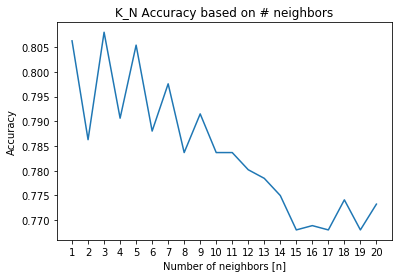

In [11]:
plt.plot(n_neigh,K_N['Accuracy'])
plt.title('K_N Accuracy based on # neighbors')
plt.xlabel('Number of neighbors [n]')
plt.ylabel('Accuracy')
plt.xticks(n_neigh)
plt.show()

Now that we have identified the optimal value for n_neighbors, let's see what our model looks like when compared to the test values. 

In [12]:
K_N_3 = KNeighborsClassifier(n_neighbors = 3)
K_N_3.fit(X_train,Y_train)
K_N_3_pred = K_N_3.predict(X_test)

perf_metrics(Y_test,K_N_3_pred)

[[598  99]
 [122 332]]
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84       697
         1.0       0.77      0.73      0.75       454

    accuracy                           0.81      1151
   macro avg       0.80      0.79      0.80      1151
weighted avg       0.81      0.81      0.81      1151



We can see that our K-Nearest Neighbor Model optimized to 3 neighbors provides a precision of predicting non-spam emails of 83%. This means that 17% of your emails would get filtered away to spam - not exactly ideal!

#### Model 3: Decision Tree Classifier

Our next approach was to use a decision tree classifier model on our dataset. One of the main parameters for a Random Forest model is the maximum depth of the splits. As with the K-Nearest-Neighbors model we will loop through various values to determine the best one. 

In [13]:
depth = range(1,21)
Tree_acc = []
for d in depth:
    Tree = tree.DecisionTreeClassifier(max_depth = d)
    Tree.fit(X_train,Y_train)
    Tree_pred = Tree.predict(X_test)
    Tree_acc.append(accuracy_score(Y_test, Tree_pred))
    
TREE = {"Max Depth":depth,'Accuracy':Tree_acc}
TREE = pd.DataFrame(TREE)
TREE.head().style.hide_index()

Max Depth,Accuracy
1,0.779322
2,0.834057
3,0.880973
4,0.889661
5,0.894874


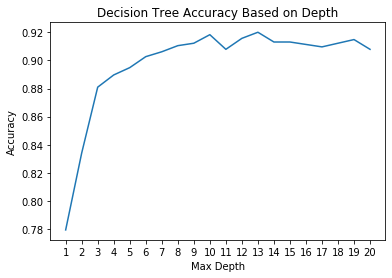

In [14]:
plt.plot(depth,TREE['Accuracy'])
plt.title('Decision Tree Accuracy Based on Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(depth)
plt.show()

In [15]:
best_depth_idx = TREE['Accuracy'].idxmax()
best_acc = max(TREE['Accuracy'])
best_dep = int(TREE.iloc[best_depth_idx]['Max Depth'])
print(f"The best accuracy of {best_acc:.2%} comes from a max depth of {best_dep}")

The best accuracy of 92.01% comes from a max depth of 13


In [16]:
Best_Tree = tree.DecisionTreeClassifier(max_depth = best_dep)
Best_Tree.fit(X_train,Y_train)
Best_Tree_pred = Best_Tree.predict(X_test)
perf_metrics(Y_test,Best_Tree_pred)

[[662  35]
 [ 62 392]]
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       697
         1.0       0.92      0.86      0.89       454

    accuracy                           0.92      1151
   macro avg       0.92      0.91      0.91      1151
weighted avg       0.92      0.92      0.92      1151



Using an optimized Decision Tree Classifier we managed to improve our Precision of actual emails to 91%, meaning only 9% of your emails would go missing. Looks like we are getting somewhere. 

**Reference: ** 